In [50]:
import cv2
import numpy as np
import pickle
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
import time
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate
from sklearn.svm import SVC
import math
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report, plot_roc_curve

Let us first read the train and test files

In [3]:
train_images_filenames = pickle.load(open('train_images_filenames.dat','rb'))
test_images_filenames = pickle.load(open('test_images_filenames.dat','rb'))
train_images_filenames = ['..' + n[15:] for n in train_images_filenames]
test_images_filenames  = ['..' + n[15:] for n in test_images_filenames]
train_labels = pickle.load(open('train_labels.dat','rb'))
test_labels = pickle.load(open('test_labels.dat','rb'))

In [4]:
train_images_filenames[12]

'../MIT_split/train/Opencountry/fie26.jpg'

We create a SIFT object detector and descriptor

In [5]:
Detector = cv2.KAZE_create(threshold=0.0001)

We compute the SIFT descriptors for all the train images and subsequently build a numpy array with all the descriptors stacked together

In [6]:
Train_descriptors = []
Train_label_per_descriptor = []

for filename,labels in zip(train_images_filenames,train_labels):
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    kpt,des=Detector.detectAndCompute(gray,None)
    Train_descriptors.append(des)
    Train_label_per_descriptor.append(labels)



We now compute a k-means clustering on the descriptor space

In [2]:
k = 128
def codebook_generator(k, descriptors):
    D=np.vstack(descriptors)
    codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
    codebook.fit(D)
    return codebook

In [ ]:
codebook = codebook_generator(k, Train_descriptors)

And, for each train image, we project each keypoint descriptor to its closest visual word. We represent each of the images with the frequency of each visual word.

In [3]:
def visual_words_generator(codebook, descriptors):
    n = len(descriptors)
    k = codebook.n_clusters
    visual_words=np.zeros((n,k),dtype=np.float32)
    for i in range(n):
        words=codebook.predict(descriptors[i])
        visual_words[i,:]=np.bincount(words,minlength=k)
    return visual_words

In [ ]:
visual_words = visual_words_generator(codebook, Train_descriptors)

We build a k-nn classifier and train it with the train descriptors

In [53]:
def build_knn(visual_words, labels, n_neighbors, metric = 'euclidean'):
    knn = KNeighborsClassifier(n_neighbors=n_neighbors,n_jobs=-1,metric=metric)
    knn.fit(visual_words, labels)
    return knn 

In [ ]:
knn = build_knn(visual_words,train_labels,5)

We end up computing the test descriptors and compute the accuracy of the model

In [10]:
visual_words_test=np.zeros((len(test_images_filenames),k),dtype=np.float32)
for i in range(len(test_images_filenames)):
    filename=test_images_filenames[i]
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    kpt,des=Detector.detectAndCompute(gray,None)
    words=codebook.predict(des)
    visual_words_test[i,:]=np.bincount(words,minlength=k)

In [7]:
def accuracy(knn, visual_words, labels):
    accuracy = 100*knn.score(visual_words, labels)
    return accuracy

In [ ]:
accuracy = accuracy(knn,visual_words_test, test_labels)
print(accuracy)

Dimensionality reduction, with PCA and LDA

In [12]:
pca = PCA(n_components=64)
VWpca = pca.fit_transform(visual_words)
knnpca = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
knnpca.fit(VWpca, train_labels) 
vwtestpca = pca.transform(visual_words_test)
accuracy = 100*knnpca.score(vwtestpca, test_labels)
print(accuracy)

57.74473358116481


In [13]:
lda = LinearDiscriminantAnalysis(n_components=7)
VWlda = lda.fit_transform(visual_words,train_labels)
knnlda = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
knnlda.fit(VWlda, train_labels) 
vwtestlda = lda.transform(visual_words_test)
accuracy = 100*knnlda.score(vwtestlda, test_labels)
print(accuracy)

64.93184634448575


### Week 2 Tasks

We compute and save all the data in train_images and test_images arrays. Doing this step we will avoid to read all the data with every task we have to do.

In [4]:
train_images_filenames = pickle.load(open('train_images_filenames.dat','rb'))
test_images_filenames = pickle.load(open('test_images_filenames.dat','rb'))
train_images_filenames = ['..' + n[15:] for n in train_images_filenames]
test_images_filenames  = ['..' + n[15:] for n in test_images_filenames]
train_labels = pickle.load(open('train_labels.dat','rb'))
test_labels = pickle.load(open('test_labels.dat','rb'))

In [5]:
train_images = []
test_images = []

for filename in train_images_filenames:
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    train_images.append(gray)
train_images=np.stack(train_images)

for filename in test_images_filenames:
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    test_images.append(gray)
test_images = np.stack(test_images)

print(f"Train images: {train_images.shape}\n Test images: {test_images.shape}")

Train images: (1881, 256, 256)
 Test images: (807, 256, 256)


### 1. Dense SIFT (with tiny steps and different scales)

Implementation of the dense SIFT with different step sizes and different scales.

In [63]:
def denseSIFT(step_size, images):
    Detector = cv2.SIFT_create()
    descriptors = []

    for image in images:
        kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, image.shape[0], step_size) 
                                            for x in range(0, image.shape[1], step_size)]
        kpt,desc = Detector.compute(image, kp)
        #dense_feat_array = list(dense_feat)
        #desc=dense_feat_array.flatten()
        #print(desc)
        descriptors.append(desc)
    
    return descriptors

accuracies = {}
#step_size = 50
for step_size in range(50,0,-10):
    start_time = time.time()
    descriptors = denseSIFT(step_size, train_images)
    codebook = codebook_generator(128, descriptors)
    visual_words = visual_words_generator(codebook, descriptors)
    knn = build_knn(visual_words, train_labels, 5)
    train_accuracy = round(100*knn.score(visual_words, train_labels), 2)

    test_descriptors = denseSIFT(step_size, test_images)
    test_visual_words = visual_words_generator(codebook, test_descriptors)
    test_accuracy = round(100*knn.score(test_visual_words, test_labels), 2)
    delta_time = round(time.time() - start_time, 2)
    accuracies[step_size] = [train_accuracy, test_accuracy, delta_time]
    print('Accuracy of the train dataset using step size of {0}: {1}'.format(step_size, train_accuracy))
    print('Accuracy of the test dataset using step size of {0}: {1}    Time: {2} seconds'.format(step_size, test_accuracy, delta_time))

Accuracy of the train dataset using step size of 50: 76.66
Accuracy of the test dataset using step size of 50: 66.91    Time: 151.61 seconds
Accuracy of the train dataset using step size of 40: 78.36
Accuracy of the test dataset using step size of 40: 70.26    Time: 156.96 seconds
Accuracy of the train dataset using step size of 30: 81.5
Accuracy of the test dataset using step size of 30: 72.24    Time: 161.92 seconds
Accuracy of the train dataset using step size of 20: 82.62
Accuracy of the test dataset using step size of 20: 77.94    Time: 160.49 seconds
Accuracy of the train dataset using step size of 10: 83.89
Accuracy of the test dataset using step size of 10: 75.96    Time: 147.33 seconds


Testing the dense SIFT with step size until 10 up to 50, we can see the accuracy reaches its maximum with the step size 20 (in the case of the evaluation of the test dataset), and then starts to decrease. In the case of the training dataset evaluation, its maximum in this case is reached with the step size of 10.
In the next code we evaluate the accuracy using some step sizes bellow 10, just to confirm that the accuracy will not get higher.

In [66]:

for step_size in range(9,0,-3):
    start_time = time.time()
    descriptors = denseSIFT(step_size, train_images)
    codebook = codebook_generator(128, descriptors)
    visual_words = visual_words_generator(codebook, descriptors)
    knn = build_knn(visual_words, train_labels, 5)
    train_accuracy = round(100*knn.score(visual_words, train_labels), 2)

    test_descriptors = denseSIFT(step_size, test_images)
    test_visual_words = visual_words_generator(codebook, test_descriptors)
    test_accuracy = round(100*knn.score(test_visual_words, test_labels),2)
    delta_time = round(time.time() - start_time,2)
    accuracies[step_size] = [train_accuracy, test_accuracy, delta_time]

    print('Accuracy of the train dataset using step size of {0}: {1} %'.format(step_size, train_accuracy))
    print('Accuracy of the test dataset using step size of {0}: {1} %    Time: {2} seconds'.format(step_size, test_accuracy, delta_time))

Accuracy of the train dataset using step size of 9: 84.1 %
Accuracy of the test dataset using step size of 9: 73.48 %    Time: 191.49 seconds
Accuracy of the train dataset using step size of 6: 82.51 %
Accuracy of the test dataset using step size of 6: 73.23 %    Time: 207.97 seconds
Accuracy of the train dataset using step size of 3: 81.45 %
Accuracy of the test dataset using step size of 3: 70.14 %    Time: 456.75 seconds


As we can see, there is no improvement for the test dataset by reducing the step size bellow 10, and also when we try to train the algorithm using a step size of 1, we have an error of lack of memory in a function from opencv library. But in the case of the evaluation of the training dataset, we can see that the accuracy improves for the step size of 9, and then it decreases for the step size 6 and 3.
Finally, we will test with tiny step size variations between 10 an 20, where it seems that probably we will have the best accuracy results.

In [67]:
for step_size in range(12,20,2):
    start_time = time.time()
    descriptors = denseSIFT(step_size, train_images)
    codebook = codebook_generator(128, descriptors)
    visual_words = visual_words_generator(codebook, descriptors)
    knn = build_knn(visual_words, train_labels, 5)
    train_accuracy = round(100*knn.score(visual_words, train_labels), 2)

    test_descriptors = denseSIFT(step_size, test_images)
    test_visual_words = visual_words_generator(codebook, test_descriptors)
    test_accuracy = round(100*knn.score(test_visual_words, test_labels), 2)
    delta_time = round(time.time() - start_time, 2)
    accuracies[step_size] = [train_accuracy, test_accuracy, delta_time]

    print('Accuracy of the train dataset using step size of {0}: {1} %'.format(step_size, train_accuracy))
    print('Accuracy of the test dataset using step size of {0}: {1} %    Time: {2} seconds'.format(step_size, test_accuracy, delta_time))

Accuracy of the train dataset using step size of 12: 84.21 %
Accuracy of the test dataset using step size of 12: 76.83 %    Time: 139.35 seconds
Accuracy of the train dataset using step size of 14: 83.79 %
Accuracy of the test dataset using step size of 14: 76.7 %    Time: 140.51 seconds
Accuracy of the train dataset using step size of 16: 82.99 %
Accuracy of the test dataset using step size of 16: 75.84 %    Time: 132.05 seconds
Accuracy of the train dataset using step size of 18: 84.05 %
Accuracy of the test dataset using step size of 18: 74.47 %    Time: 134.52 seconds


As we can see, we reach a very good results in the step sizes between 10 and 20, but the step size of 20 still being the best for us when we evaluate the test dataset. However, in the case of the training dataset, we reach the best result using a step size of 12. For the next experiments we will use only the step sizes of 12 and 20.

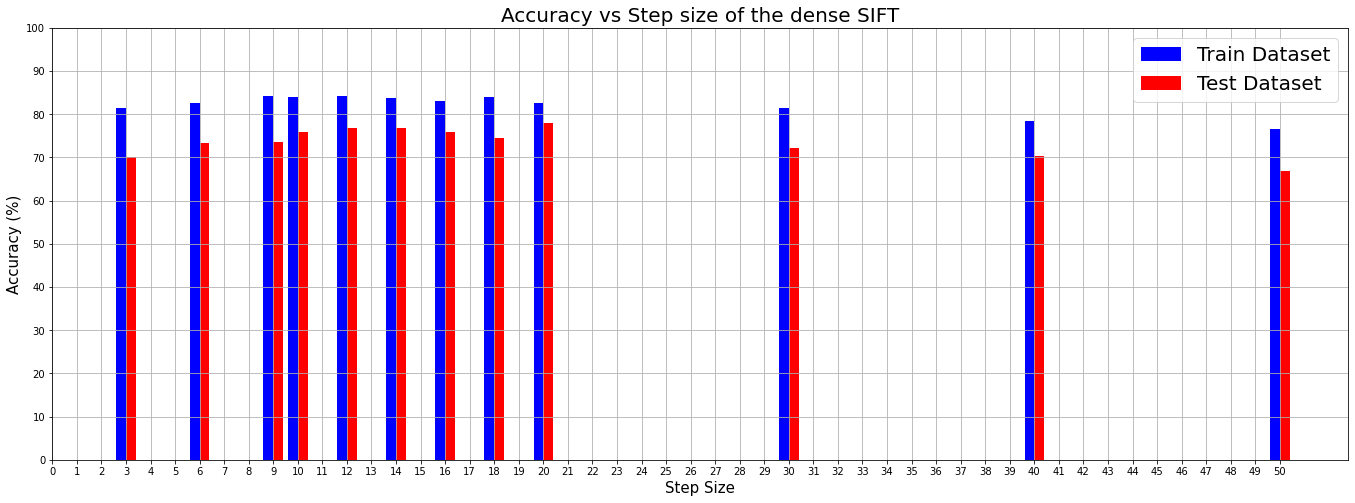

In [68]:


X = sorted(accuracies)

fig = plt.figure()
ax = fig.add_axes([0,0,3,1.5])
for i in X:
    ax.bar(i - 0.2, accuracies[i][0], color = 'b', width = 0.4)
    ax.bar(i + 0.2, accuracies[i][1], color = 'r', width = 0.4)
    #ax.bar(i + 0.50, accuracies[i][2], color = 'r', width = 0.25)

ax.legend(labels=['Train Dataset', 'Test Dataset'], fontsize=20)
ax.set_ylabel('Accuracy (%)', fontsize=15)
ax.set_xlabel('Step Size', fontsize=15)
ax.set_title('Accuracy vs Step size of the dense SIFT', fontsize=20)
ax.set_xticks(np.arange(0,51, 1))
ax.set_yticks(np.arange(0, 101, 10))
plt.grid()

In [73]:


df = pd.DataFrame(index=['Accuracy Training dataset (%)','Accuracy Test Dataset (%)','Execution Time (s)'])
for key in X:
    df[key] = accuracies[key]
#df = pd.DataFrame(accuracies[key], index=['Accuracy Training dataset (%)','Accuracy Test Dataset (%)','Execution Time (s)'])

print (df)

                                   3       6       9       10      12      14  \
Accuracy Training dataset (%)   81.45   82.51   84.10   83.89   84.21   83.79   
Accuracy Test Dataset (%)       70.14   73.23   73.48   75.96   76.83   76.70   
Execution Time (s)             456.75  207.97  191.49  147.33  139.35  140.51   

                                   16      18      20      30      40      50  
Accuracy Training dataset (%)   82.99   84.05   82.62   81.50   78.36   76.66  
Accuracy Test Dataset (%)       75.84   74.47   77.94   72.24   70.26   66.91  
Execution Time (s)             132.05  134.52  160.49  161.92  156.96  151.61  


To test different values of the scale, we modified the sigma parameter of the dense SIFT descriptor. As we knew that the default value was 1.6, we iterated between 1.4 and 1.8 with small step sizes of 0.05 to get the best performance.

In [15]:


accuracies12 = {}
accuracies20 = {}

def denseSIFT(step_size, images, sigma):
    Detector = cv2.SIFT_create(sigma=sigma)
    descriptors = []

    for image in images:
        kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, image.shape[0], step_size) 
                                            for x in range(0, image.shape[1], step_size)]
        kpt,desc = Detector.compute(image, kp)
        #dense_feat_array = list(dense_feat)
        #desc=dense_feat_array.flatten()
        #print(desc)
        descriptors.append(desc)
    
    return descriptors

sigma = np.arange(1.45,1.7,0.05)
step_sizes = [12,20]
for step_size in step_sizes:
    
    for i in sigma:
        start_time = time.time()
        descriptors = denseSIFT(step_size, train_images,sigma=i)
        codebook = codebook_generator(128, descriptors)
        visual_words = visual_words_generator(codebook, descriptors)
        knn = build_knn(visual_words, train_labels, 5)
        train_accuracy = 100*knn.score(visual_words, train_labels)
        
        test_descriptors = denseSIFT(step_size, test_images,sigma=i)
        test_visual_words = visual_words_generator(codebook, test_descriptors)
        test_accuracy = 100*knn.score(test_visual_words, test_labels)
        delta_time = time.time() - start_time

        if step_size == 12:

            accuracies12[i] = [train_accuracy, test_accuracy]

        else:
            accuracies20[i] = [train_accuracy, test_accuracy]

        print('Accuracy of the train dataset using step size of {0}, and a sigma value of {1}: {2} %'.format(step_size, i,train_accuracy))
        print('Accuracy of the test dataset using step size of {0}, and a sigma value of {1}: {2} %    Time: {3} seconds'.format(step_size, i,test_accuracy, delta_time)) 


Accuracy of the train dataset using step size of 12, and a sigma value of 1.45: 83.35991493886232 %
Accuracy of the test dataset using step size of 12, and a sigma value of 1.45: 77.44733581164807 %    Time: 123.25076580047607 seconds
Accuracy of the train dataset using step size of 12, and a sigma value of 1.5: 84.15736310473153 %
Accuracy of the test dataset using step size of 12, and a sigma value of 1.5: 75.71251548946717 %    Time: 112.12463665008545 seconds
Accuracy of the train dataset using step size of 12, and a sigma value of 1.55: 83.20042530568847 %
Accuracy of the test dataset using step size of 12, and a sigma value of 1.55: 76.08426270136307 %    Time: 118.19219541549683 seconds
Accuracy of the train dataset using step size of 12, and a sigma value of 1.6: 82.93460925039872 %
Accuracy of the test dataset using step size of 12, and a sigma value of 1.6: 76.08426270136307 %    Time: 118.38383197784424 seconds
Accuracy of the train dataset using step size of 12, and a sigma

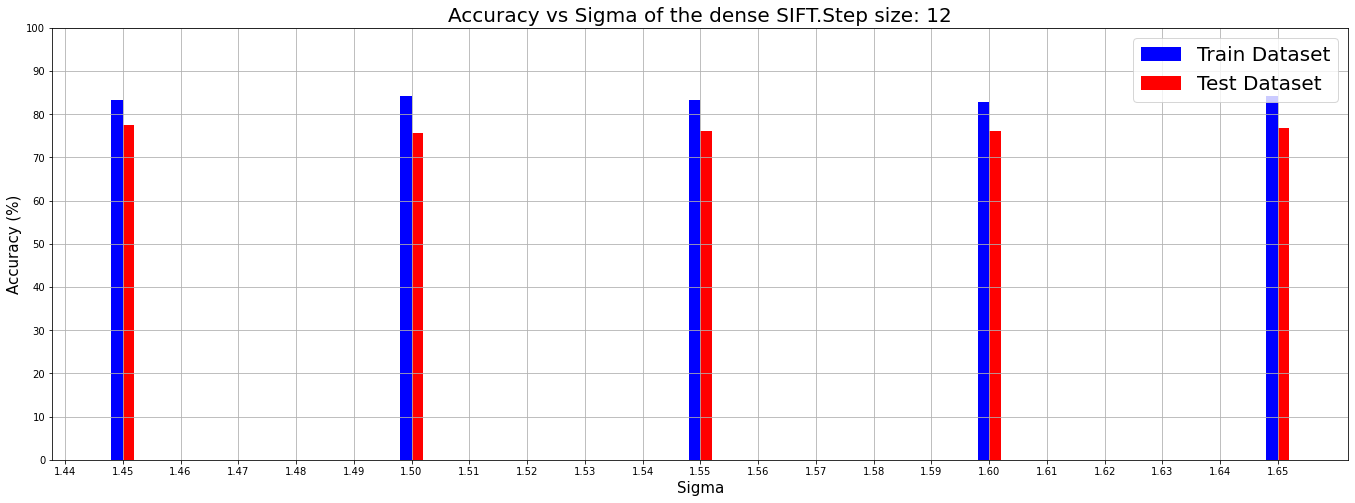

In [26]:
X = sorted(accuracies12)
fig = plt.figure()
axs = fig.add_axes([1,0,3,1.5])
for i in X:
    axs.bar(i - 0.001, accuracies12[i][0], color = 'b', width = 0.002)
    axs.bar(i +0.001, accuracies12[i][1], color = 'r', width = 0.002)
    #ax.bar(i + 0.50, accuracies[i][2], color = 'r', width = 0.25)
    axs.set_xticks(np.arange(1.44,1.66, 0.01))
    axs.set_yticks(np.arange(0, 101, 10))

axs.legend(labels=['Train Dataset', 'Test Dataset'], fontsize=20)
axs.set_xticks(np.arange(1.44,1.66, 0.01))
axs.set_yticks(np.arange(0, 101, 10))
axs.set_ylabel('Accuracy (%)', fontsize=15)
axs.set_xlabel('Sigma', fontsize=15)


axs.set_title('Accuracy vs Sigma of the dense SIFT.Step size: 12', fontsize=20)
plt.grid()

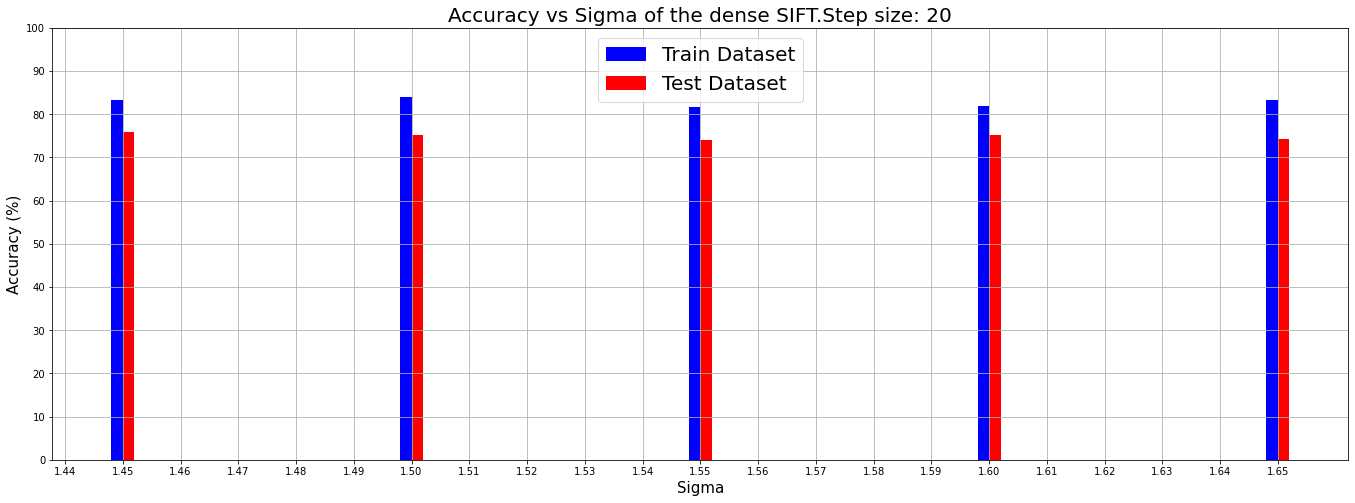

In [27]:
X = sorted(accuracies20)
fig = plt.figure()
axs = fig.add_axes([1,0,3,1.5])
for i in X:
    axs.bar(i - 0.001, accuracies20[i][0], color = 'b', width = 0.002)
    axs.bar(i +0.001, accuracies20[i][1], color = 'r', width = 0.002)
    #ax.bar(i + 0.50, accuracies[i][2], color = 'r', width = 0.25)
    

axs.legend(labels=['Train Dataset', 'Test Dataset'], fontsize=20)
axs.set_xticks(np.arange(1.44,1.66, 0.01))
axs.set_yticks(np.arange(0, 101, 10))
axs.set_ylabel('Accuracy (%)', fontsize=15)
axs.set_xlabel('Sigma', fontsize=15)


axs.set_title('Accuracy vs Sigma of the dense SIFT.Step size: 20', fontsize=20)
plt.grid()

It seems that the best accuracy was obtained with a sigma of 1.45 for both cases in the test_set, step size= 12 and step size=20. From now on a sigma of 1.45 will be used.

### 2. Normalize the feature descriptors

Normalization refers to rescaling real-valued numeric attributes into a 0 to 1 range.

Data normalization is used in machine learning to make model training less sensitive to the scale of features. This allows our model to converge to better weights and, in turn, leads to a more accurate model.

The function used for finding norms of vectors and matrices is called norm and can be called in Python as numpy.linalg.norm(x). The function returns different results, depending on the value passed for argument x. Generally, x is a vector or a matrix, i.e a 1-D or a 2-D NumPy array.

This function takes a second parameter called ord, which determines the type of norm to be calculated on the array. The default value for this is None, in which case we get the 2-norm(popularly known as the ‘L2 norm’ or ‘Euclidean norm’) of a vector.

In [19]:
def denseSIFT_norm(step_size, images):
    Detector = cv2.SIFT_create(sigma = 1.45)
    descriptors = []

    for image in images:
        kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, image.shape[0], step_size) 
                                            for x in range(0, image.shape[1], step_size)]
        kpt,desc = Detector.compute(image, kp)
        #dense_feat_array = list(dense_feat)
        #desc=dense_feat_array.flatten()
        #print(desc)
        desc_norm = np.linalg.norm(desc)
        desc_normalized = desc/desc_norm
        descriptors.append(desc_normalized)
    
    return descriptors

step_sizes = [12,20]

for step_size in step_sizes:
    start_time = time.time()
    descriptors = denseSIFT_norm(step_size, train_images)
    codebook = codebook_generator(128, descriptors)
    visual_words = visual_words_generator(codebook, descriptors)
    knn = build_knn(visual_words, train_labels, 5)
    train_accuracy = round(100*knn.score(visual_words, train_labels), 2)

    test_descriptors = denseSIFT_norm(step_size, test_images)
    test_visual_words = visual_words_generator(codebook, test_descriptors)
    test_accuracy = round(100*knn.score(test_visual_words, test_labels), 2)
    delta_time = round(time.time() - start_time, 2)
    print('Accuracy of the train dataset using step size of {0}: {1} %'.format(step_size, train_accuracy))
    print('Accuracy of the test dataset using step size of {0}: {1} %    Time: {2} seconds'.format(step_size, test_accuracy, delta_time))

Accuracy of the train dataset using step size of 12: 84.0 %
Accuracy of the test dataset using step size of 12: 74.97 %    Time: 118.84 seconds
Accuracy of the train dataset using step size of 20: 83.25 %
Accuracy of the test dataset using step size of 20: 74.1 %    Time: 149.33 seconds


As we can see, after performing the normalization of the descriptors using the L2 norm, there is an improvement of the accuracy in the training set. but in the case of the test set the accuracy decreases.

### 3. Cross-Validation

Cross-validation is a resampling methology that is used to evaluate the consistency of a machine learning model. It has a single parameter called k that refers to the number of groups that a dataset is to be split into. For each group, it takes one group as test data set and the remaining as training data set. Then, the model is fitted on the on the training set and evaluate it on the test set. This procedure is done it for all groups. Finally, the final accuracy of the model is calculated by doing the mean value of the different tests. 

In this exercise, we will specify that the split groups of the data have the same distribution of the target variable, which is called "stratified split". Firstly we will perform the cross valitation of the model in order to decide the final step size value. Secondly, we will use it to perform a parameter optimization on the number of neighbors.


##### 3.1. Cross-validation of the kNN model in the optimization of the step size

In [16]:


def accuracy_CV_KNN(visual_words, labels, n_neighbors=5, metric = 'euclidean'):
    knn = KNeighborsClassifier(n_neighbors=n_neighbors,n_jobs=-1,metric=metric)  # Compute distances with all samples and peak the label of majority k nearest
    skf=StratifiedKFold(n_splits=5)
    cv_results=cross_validate(knn, visual_words, labels, cv=skf)

    return 100*np.mean(cv_results['test_score'])

def denseSIFT_norm(step_size, images):
    Detector = cv2.SIFT_create(sigma = 1.45)
    descriptors = []

    for image in images:
        kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, image.shape[0], step_size) 
                                            for x in range(0, image.shape[1], step_size)]
        kpt,desc = Detector.compute(image, kp)
        #dense_feat_array = list(dense_feat)
        #desc=dense_feat_array.flatten()
        #print(desc)
        desc_norm = np.linalg.norm(desc)
        desc_normalized = desc/desc_norm
        descriptors.append(desc_normalized)
    
    return descriptors

In [21]:
step_sizes=[12,20]

for step_size in step_sizes:
    start_time = time.time()
    descriptors = denseSIFT_norm(step_size, train_images)
    codebook = codebook_generator(128, descriptors)
    visual_words = visual_words_generator(codebook, descriptors)
    knn = build_knn(visual_words, train_labels, 5)
    train_accuracy = round(100*knn.score(visual_words, train_labels), 2)
    train_accuracy_cv=accuracy_CV_KNN(visual_words=visual_words, labels=train_labels, n_neighbors=5)
    
    test_descriptors = denseSIFT_norm(step_size, test_images)
    test_visual_words = visual_words_generator(codebook, test_descriptors)
    test_accuracy = round(100*knn.score(test_visual_words, test_labels), 2)
    delta_time = round(time.time() - start_time, 2)

    print('Accuracy of the train dataset using step size of {0}: {1} %'.format(step_size, train_accuracy))
    print('Accuracy of the cross-validated train dataset using step size of {0}: {1} % '.format(step_size, train_accuracy_cv))
    print('Accuracy of the test dataset using step size of {0}: {1} %    Time: {2} seconds'.format(step_size, test_accuracy, delta_time))

Accuracy of the train dataset using step size of 12: 83.79 %
Accuracy of the cross-validated train dataset using step size of 12: 74.16346859303574 % 
Accuracy of the test dataset using step size of 12: 76.58 %    Time: 223.53 seconds
Accuracy of the train dataset using step size of 20: 84.58 %
Accuracy of the cross-validated train dataset using step size of 20: 74.3236074270557 % 
Accuracy of the test dataset using step size of 20: 77.45 %    Time: 132.26 seconds


The K-fold cross validation method shows us the model accuracy values much closer to reality, i.e. those obtained with the test set. This method is very useful to know how good our system really is and allows us to fine-tune the hyperparameters of our algorithm in a much more accurate way without overfitting. 

Once the cross validation is done, we see that the best accuracy is obtained with a step size of 20 in both the training set and the test set, so from now on we will use this value.

##### 3.2. Hyperparameter optimization in KNN with cross validation

In this section we will use the gridsearchcv function to perform an optimization of the model, i.e. to find the best parameters for our starting data. From the parameters of the knn model, we can tune the number of neighbors, the weight of the neighbors and the metric. At this point, we will focus only on the number of neighbors and we will skip the other two. In the case of the metric, in week 1 we could already see that the one that gave the best results was the Euclidean one.  

As in the previous section, we will specify that the split groups of the data have the same distribution of the target variable, which is called "stratified split".


In [22]:
step_size=20
descriptors = denseSIFT_norm(step_size, train_images)
codebook = codebook_generator(128, descriptors)
visual_words = visual_words_generator(codebook, descriptors)

grid_params= {
    'n_neighbors':[5,11,19,27,31]
}
skf=StratifiedKFold(n_splits=5)
grid=GridSearchCV(KNeighborsClassifier(n_jobs=-1,metric='euclidean'),grid_params,verbose=1,cv=skf)

grid_results = grid.fit(visual_words,train_labels)
print("The best parameters for the model are: ", grid_results.best_params_)

accuracy = grid_results.best_score_ *100
print("Accuracy for our training dataset with the best tunned model : {0}%".format(accuracy) )

Fitting 5 folds for each of 5 candidates, totalling 25 fits
The best parameters for the model are:  {'n_neighbors': 19}
Accuracy for our training dataset with the best tunned model : 75.70545741859021%


In [23]:
best_knn=build_knn(visual_words, train_labels, n_neighbors= 19)
test_descriptors = denseSIFT_norm(step_size, test_images)
test_visual_words = visual_words_generator(codebook, test_descriptors)
test_accuracy = round(100*best_knn.score(test_visual_words, test_labels), 2)

print("Accuracy for our test dataset with the best model is : {0}%".format(test_accuracy) )

Accuracy for our test dataset with the best model is : 75.71%


Finally, we can see that after this step the accuracy achieved with the training set and with the test set is very similar. This means that the system has a lot of consistency.

### 4. SVM Classifier

- Use sklearn standardScaler to project every dimension to [0,1]
- Use Linear Kernel
- Use RBF kernel
- Use Histogram intersection Kernel

Standardisation is a scaling technique in which values are centred around the mean with a unit standard deviation. This means that the mean of the attribute becomes zero and the resulting distribution has a unit standard deviation.
First, we will standarise our data to see which feature scaling works best in our dataset, standardisation or normalisation.

In [54]:
def denseSIFT_std(step_size, images):
    Detector = cv2.SIFT_create(sigma = 1.45)
    descriptors = []
    scaler = StandardScaler()
    for image in images:
        kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, image.shape[0], step_size) 
                                            for x in range(0, image.shape[1], step_size)]
        kpt,desc = Detector.compute(image, kp)
        #dense_feat_array = list(dense_feat)
        #desc=dense_feat_array.flatten()
        #print(desc)
        desc_standardised = scaler.fit_transform(desc)
        descriptors.append(desc_standardised)
    
    
    return descriptors

step_sizes = 20
start_time = time.time()
descriptors = denseSIFT_std(step_size, train_images)
codebook = codebook_generator(128, descriptors)
visual_words = visual_words_generator(codebook, descriptors)
knn = build_knn(visual_words, train_labels, 5)
train_accuracy = round(100*knn.score(visual_words, train_labels), 2)

test_descriptors = denseSIFT_std(step_size, test_images)
test_visual_words = visual_words_generator(codebook, test_descriptors)
test_accuracy = round(100*knn.score(test_visual_words, test_labels), 2)
delta_time = round(time.time() - start_time, 2)
print('Accuracy of the train dataset using step size of {0}: {1} %'.format(step_size, train_accuracy))
print('Accuracy of the test dataset using step size of {0}: {1} %    Time: {2} seconds'.format(step_size, test_accuracy, delta_time))

Accuracy of the train dataset using step size of 20: 76.02 %
Accuracy of the test dataset using step size of 20: 64.19 %    Time: 178.01 seconds


As we can see we get worse results when we standardise our data. The feaure scaling depends on the distribution of the dataset, in the cases that follow a gaussian distribution it is recommended to use standardisation, the rest of the cases it is better to normalise. Therefore, we will continue normalising our data in the rest of the tasks.

The SVM predictor have 3 hyper-parameters to take into account:
1. Kernels: The main function of this parameter is to take low dimensional input space and transform it into a higher-dimensional space.
2. C (Regularisation): C is the penalty parameter, which represents misclassification or error term. 
3. Gamma: It defines how far influences the calculation of plausible line of separation.
 In order to improve our model accuracy these parameters need to be tuned. To do so a GridSearch was done:

In [56]:

#Definition of Hyper-parameters:
param = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'linear', 'sigmoid']}

def build_SVC(visual_words, labels):
    skf = StratifiedKFold(n_splits=5)
    SVC_grid = GridSearchCV(SVC(),param,refit=True,cv=skf)
    SVC_grid.fit(visual_words,labels)
    print('Best estimator:',SVC_grid.best_estimator_)
    return SVC_grid

#svc = build_SVC(visual_words,train_labels)

step_size = 20

start_time = time.time()
descriptors = denseSIFT_norm(step_size, train_images)
codebook = codebook_generator(128, descriptors)
visual_words = visual_words_generator(codebook, descriptors)
svc = build_SVC(visual_words, train_labels)


test_descriptors = denseSIFT_norm(step_size, test_images)
test_visual_words = visual_words_generator(codebook, test_descriptors)
test_prediction = svc.predict(test_visual_words)
delta_time = round(time.time() - start_time, 2)

print('Step size:{0}'.format(step_size))
print(classification_report(test_labels,test_prediction))

print( 'Time: {0} seconds'.format(delta_time))

Best estimator: SVC(C=1, gamma=0.001)
Step size:20
              precision    recall  f1-score   support

 Opencountry       0.71      0.65      0.68       118
       coast       0.75      0.86      0.80       116
      forest       0.86      0.94      0.90       101
     highway       0.84      0.76      0.80        76
 inside_city       0.89      0.78      0.83        94
    mountain       0.81      0.78      0.79       114
      street       0.88      0.89      0.88        80
tallbuilding       0.81      0.85      0.83       108

    accuracy                           0.81       807
   macro avg       0.82      0.81      0.81       807
weighted avg       0.81      0.81      0.81       807

Time: 389.34 seconds


As we can see, the accuracy of the test set has increased after using the SVM classifier. This makes a lot of sense, since in classification tasks the SVM is better than most of the other algorithms used in terms of accuracy. One of the main reasons is the fact that SVM provides a very useful technique within it, the kernel function, by the application of this function we can solve any complex problem. Thus the kernel provides the choice of a function which is not necessarily linear and can have different forms in terms of the different data, thus Input data can be converted into High dimensional data avoiding the need of this assumption.

### 5. Spatial Pyramids

One of the disadvantages of using BoW is that it ignores the spatial information of the image descriptors. One way to solve this problem is to use an algorithm called Spatial Pyramid Matching (SPM). This algorithm consists of creating a vector of descriptors as follows:
1) The image is divided into different blocks (1 block at level 0, 4 at level 1 and 16 at level 2).
2) In each level and in each block, the search for features (SIFT or dense SIFT, etc) is performed.
3) Then, the number of features of each type per block is counted (creating a histogram) and the concatenation of the histograms of the different features is carried out.
3) Finally, a single vector is made by concatenating the information of the 3 levels.
Once the new vector of descriptors is obtained, it is introduced in the classifier (SVM or KNN) as input, as if it were the vector resulting from the SIFT dense directly.

In this exercise, we will perform a 3-level SPM and it will be used in the best SVM model that we have found in the previous


In [6]:
def denseSIFT_norm(step_size, images):
    Detector = cv2.SIFT_create(sigma = 1.45)
    descriptors = []

    for image in images:
        kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, image.shape[0], step_size) 
                                            for x in range(0, image.shape[1], step_size)]
        kpt,desc = Detector.compute(image, kp)
        desc_norm = np.linalg.norm(desc)
        desc_normalized = desc/desc_norm
        descriptors.append(desc_normalized)
    
    return descriptors

In [31]:

def denseSIFT_SPM(img):
    DSIFT_STEP_SIZE = 2
    sift = cv2.xfeatures2d.SIFT_create()
    disft_step_size = DSIFT_STEP_SIZE
    keypoints = [cv2.KeyPoint(x, y, disft_step_size)
            for y in range(0, img.shape[0], disft_step_size)
                for x in range(0, img.shape[1], disft_step_size)]

    descriptors = sift.compute(img, keypoints)[1]
    return descriptors

# form histogram with Spatial Pyramid Matching upto level L with codebook kmeans and k codewords
def getImageFeaturesSPM(L, img, kmeans, k):
    W = img.shape[1]
    H = img.shape[0]   
    h = []
    for l in range(L+1):
        w_step = math.floor(W/(2**l))
        h_step = math.floor(H/(2**l))
        x, y = 0, 0
        for i in range(1,2**l + 1):
            x = 0
            for j in range(1, 2**l + 1):                
                desc = denseSIFT_SPM(img[y:y+h_step, x:x+w_step])                
                #print("type:",desc is None, "x:",x,"y:",y, "desc_size:",desc is None)
                predict = kmeans.predict(desc)
                histo = np.bincount(predict, minlength=k).reshape(1,-1).ravel()
                weight = 2**(l-L)
                h.append(weight*histo)
                x = x + w_step
            y = y + h_step
            
    hist = np.array(h).ravel()
    # normalize hist
    dev = np.std(hist)
    hist -= np.mean(hist)
    hist /= dev
    return hist


# get histogram representation for training/testing data
def getHistogramSPM(L, data, kmeans, k):    
    x = []
    for i in range(len(data)):        
        hist = getImageFeaturesSPM(L, data[i], kmeans, k)        
        x.append(hist)
    return np.array(x)

In [17]:
# build BoW presentation from SIFT of training images 
def clusterFeatures(descriptors, k):
    D=np.vstack(descriptors)
    kmeans = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
    return kmeans.fit(D)

In [33]:
step_size=20
descriptors = denseSIFT_norm(step_size,train_images)
k = 128
codebook = codebook_generator(k, descriptors)
train_histo = getHistogramSPM(2, train_images, codebook, k)
test_histo = getHistogramSPM(2, test_images, codebook, k)

In [34]:
clf = SVC(C=0.1,gamma=1,kernel='linear')
clf.fit(train_histo, train_labels)
test = clf.predict(test_histo)

print(classification_report(test_labels,test))

              precision    recall  f1-score   support

 Opencountry       0.70      0.76      0.73       118
       coast       0.82      0.85      0.84       116
      forest       0.90      0.91      0.91       101
     highway       0.89      0.82      0.85        76
 inside_city       0.89      0.88      0.89        94
    mountain       0.82      0.79      0.80       114
      street       0.87      0.81      0.84        80
tallbuilding       0.88      0.89      0.88       108

    accuracy                           0.84       807
   macro avg       0.85      0.84      0.84       807
weighted avg       0.84      0.84      0.84       807



We can see that taking into account the spatial distribution of the descriptors the accuracy of our model improves.

Finally, to further improve our algorithm we will use the histogram intersection kernel. This kernel calculates the similarity of two discretized probability distributions (histograms), with possible value of the intersection lying between 0 (no overlap) and 1 (identical distributions).

In [48]:
def HIK(data_1, data_2):
    kernel = np.zeros((data_1.shape[0], data_2.shape[0]))

    for d in range(data_1.shape[1]):
        column_1 = data_1[:, d].reshape(-1, 1)
        column_2 = data_2[:, d].reshape(-1, 1)
        kernel += np.minimum(column_1, column_2.T)

    return kernel


clf = SVC(C=0.1,gamma=1,kernel=HIK)
clf.fit(train_histo, train_labels)
test = clf.predict(test_histo)

print(classification_report(test_labels,test))

              precision    recall  f1-score   support

 Opencountry       0.79      0.81      0.79       118
       coast       0.82      0.84      0.83       116
      forest       0.90      0.94      0.92       101
     highway       0.89      0.83      0.86        76
 inside_city       0.94      0.86      0.90        94
    mountain       0.86      0.82      0.84       114
      street       0.88      0.89      0.88        80
tallbuilding       0.88      0.94      0.91       108

    accuracy                           0.86       807
   macro avg       0.87      0.87      0.87       807
weighted avg       0.87      0.86      0.86       807



As we can see the best result is obtained using SVM as a classifier with an intersection kernel between histograms.